<img height="50px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

# Deep Model Diver Testing

This notebook is designed to test the various functions (feature extraction, feature reduction, metadata collection and preliminary benchmarking) in the [Github](https://github.com/ColinConwell/DeepModelDiver) repo.



To edit this notebook, first click **File > Save a copy in drive**.

Rename the notebook with the name of the model being tested.

To navigate the notebook, simply click on a cell and hit **Shift + Enter**.


In [1]:
#The first step is downloading the packages we'll need, and cloning the Github repo.
!pip install -q git+https://github.com/rwightman/pytorch-image-models 
!pip install -q --upgrade scikit-learn visualpriors
# !git clone https://github.com/ColinConwell/DeepModelDiver/

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os, sys, json
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from copy import copy
from tqdm.auto import tqdm as tqdm
from plotnine import *

np.random.seed(123)

ModuleNotFoundError: No module named 'plotnine'

In [ ]:
sys.path.append('DeepModelDiver')

## Choose Your Model

Any feedforward PyTorch model that takes in images (or video frames) as input will do. Our ultimate goal will be to add this model to our running list of available models, the current version of which we can load as follows:

In [3]:
from DeepDive.model_options import *
model_options = get_model_options()

***model_options*** is a nested dictionary (where each key is a *model_string* of the form *model_name_train_type*).

In [4]:
list(model_options.keys())[1::20]

['alexnet_imagenet',
 'resnet34_imagenet',
 'googlenet_imagenet',
 'inception_v3_imagenet',
 'curvature_taskonomy',
 'vanishing_point_taskonomy',
 'eca_nfnet_l0_random',
 'hardcorenas_f_random',
 'mobilenetv3_rw_random',
 'repvgg_b3_random',
 'skresnet18_random',
 'tf_efficientnet_b7_random',
 'vit_small_patch16_224_random']

Each entry in ***model_options*** contains key information about the model, including:


*   train_type: is the model pretrained or randomly initialized? if it was trained, how was it trained? (e.g. with imagenet?)
*   model_type: what kind of model is this? (segmentation, detection, classification?)
*   model_source: where does the model originate? (torchvision? facebookresearch?)
*   call: what is the function for loading the model?



In [5]:
model_options['alexnet_imagenet'] #here is the information for alexnet_imagenet

{'model_name': 'alexnet',
 'model_type': 'imagenet',
 'train_type': 'imagenet',
 'model_source': 'torchvision',
 'call': 'models.alexnet(pretrained=True)'}

In the steps below, we'll load our model from source and add it as an entry into our ***model_options*** dictionary.

In [6]:
model_string = 'autoencoding_taskonomy'
model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']

model = eval(model_call) 
model = model.eval() 
if torch.cuda.is_available(): 
  model = model.cuda()

image_transforms = get_recommended_transforms(model_string)

Downloading: "https://github.com/alexsax/visual-prior/raw/networks/assets/pytorch/autoencoding_encoder-e35146c09253720e97c0a7f8ee4e896ac931f5faa1449df003d81e6089ac6307.pth" to /Users/garyk/.cache/torch/hub/checkpoints/autoencoding_encoder-e35146c09253720e97c0a7f8ee4e896ac931f5faa1449df003d81e6089ac6307.pth


In [8]:
list(model.parameters())[1]

Parameter containing:
tensor([1.0262, 0.9731, 1.0123, 1.0255, 0.9517, 0.9062, 0.9572, 1.0206, 0.9824,
        0.9795, 0.9653, 0.9732, 1.0088, 0.9667, 1.0228, 1.0072, 0.9481, 1.0441,
        1.0338, 0.9702, 1.0115, 1.0292, 1.0179, 0.9395, 1.0365, 1.0303, 1.0224,
        1.0720, 0.9943, 1.0307, 0.9704, 0.8103, 1.0095, 0.9974, 1.0254, 1.0031,
        1.0029, 0.9474, 0.9859, 1.0280, 1.0274, 0.9722, 1.0436, 1.0204, 0.9093,
        1.0160, 0.9970, 0.9517, 1.0004, 1.0069, 1.0481, 0.9838, 1.0408, 1.0321,
        0.9884, 0.9548, 0.9634, 0.9527, 1.0057, 0.9641, 1.0179, 1.0655, 0.9647,
        0.9829])

## Load Test Stimuli

Let's download some images for use in our testing...

In [9]:
#the following commands download files from Google Drive and arrange them in folders
!gdown https://drive.google.com/uc?id=1gTT1HwclbdVznBD-Z7_z3tg07M8YrE_6
!gdown https://drive.google.com/uc?id=1B5cj5lZf9_T1FwjqT5cxKxLbxIh-VstG
!tar xf oasis_images.tar.bz && mv images/oasis oasis_images && rm -rf images

/bin/bash: gdown: command not found
/bin/bash: gdown: command not found
tar: Error opening archive: Failed to open 'oasis_images.tar.bz'


...and put their paths into a dataframe for easy loading.

In [10]:
root = 'oasis_images/' # the folder where the images exist
assets = glob(root + '*.jpg') # a list of the images in the folder
asset_dictlist = [] # an empty list to which we'll add dictionary entries
for asset in assets: # looping through all images...
    image_name = asset.split('/')[-1] # we extract the image_name from the file name
    row = {'image_name': image_name} # we make a new row for this image_name
    asset_dictlist.append(row) # then add it to our list of dictionaries
image_data = (pd.DataFrame(asset_dictlist)
              .sort_values(by='image_name', ignore_index=True)) # finally, we make a dataframe out of our list of dictionaries

KeyError: 'image_name'

The end product of this process should look something like this (and most importantly, have at least one column labeled **image_name**):

In [ ]:
image_data.sample(5) # let's get a random sample of 5 rows of our image_data frame

,image_name
613,Path1.jpg
524,Neutralpose2.jpg
690,Sadface4.jpg
457,Lake12.jpg
85,Boredpose1.jpg


## Testing Feature Extraction

Feature extraction is the process wherein we pass images through the model and extract features at each successive layer of computation.

In [13]:
from DeepDive.feature_extraction import * #loading functions for feature extraction

To start the process, we make what's called a dataloader, storing our images in such a way that our model can more easily access them.

In [14]:
image_loader = DataLoader(dataset=StimulusSet(image_data, root, image_transforms), batch_size=64)
# notice, we tell the dataloader to use our image_transforms; a batch size of 64 means we'll load 64 images at a time

NameError: name 'image_data' is not defined

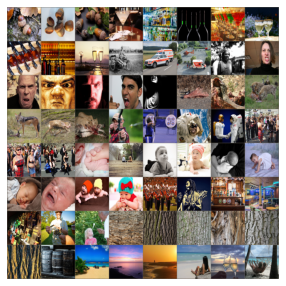

In [ ]:
# if our dataloader's worked correctly, it should return a grid of images:
get_dataloader_sample(image_loader, nrow = 8)

Next, we run the extraction -- a function that will return to us an ordered dictionary, wherein each successive entry is a layer of computation.

In [ ]:
model_inputs = next(iter(image_loader))[:3] # for now, we'll test our feature extraction with only three images...
feature_maps = get_all_feature_maps(model, model_inputs)

In [ ]:
# these are the names of each model layer
model_layer_names = list(feature_maps.keys())
print(model_layer_names)

['Conv2d-1', 'PatchEmbed-1', 'Dropout-1', 'LayerNorm-1', 'Linear-1', 'Dropout-2', 'Linear-2', 'LayerNorm-2', 'Linear-3', 'GELU-1', 'Linear-4', 'Block-1', 'LayerNorm-3', 'Linear-5', 'Dropout-6', 'Linear-6', 'LayerNorm-4', 'Linear-7', 'GELU-2', 'Linear-8', 'Block-2', 'LayerNorm-5', 'Linear-9', 'Dropout-10', 'Linear-10', 'LayerNorm-6', 'Linear-11', 'GELU-3', 'Linear-12', 'Block-3', 'LayerNorm-7', 'Linear-13', 'Dropout-14', 'Linear-14', 'LayerNorm-8', 'Linear-15', 'GELU-4', 'Linear-16', 'Block-4', 'LayerNorm-9', 'Linear-17', 'Dropout-18', 'Linear-18', 'LayerNorm-10', 'Linear-19', 'GELU-5', 'Linear-20', 'Block-5', 'LayerNorm-11', 'Linear-21', 'Dropout-22', 'Linear-22', 'LayerNorm-12', 'Linear-23', 'GELU-6', 'Linear-24', 'Block-6', 'LayerNorm-13', 'Linear-25', 'Dropout-26', 'Linear-26', 'LayerNorm-14', 'Linear-27', 'GELU-7', 'Linear-28', 'Block-7', 'LayerNorm-15', 'Linear-29', 'Dropout-30', 'Linear-30', 'LayerNorm-16', 'Linear-31', 'GELU-8', 'Linear-32', 'Block-8', 'LayerNorm-17', 'Linear-33

Each entry in this dictionary is an array whose shape corresponds to the number of stimuli by the number of flattened activations in that layer.

In [ ]:
feature_maps['Linear-1'].shape # 3 stimuli x ~300,000 features

## Testing Dimensionality Reduction

Once we've extracted our model features (activations), we generally need to reduce their dimensionality. Here, we test the extraction of sparse random projections (a form of dimensionality reduction) from the feature maps corresponding to each model layer.

In [ ]:
from feature_reduction import * #loading functions for feature reduction

For the purposes of this test, we'll subset from our full set of feature maps (layers) every 3rd linear layer, starting with the first.

In [ ]:
feature_maps_subset = {map_key: map_item  for (map_key, map_item) in feature_maps.items() 
                          if 'Linear' in map_key and int(map_key[-1]) % 3 == 1}

In [ ]:
len(feature_maps_subset) #subsetting in this way leaves us 15 feature maps...

We then perform our dimensionality reduction using another wrapper function we've written to facilitate the process, producing a dictionary in which each key corresponds to a layer, and each value corresponds to the dimensionality reduced feature map for that layer.

In [ ]:
feature_maps_reduced = srp_extraction(model_string, model, feature_maps = feature_maps_subset, 
                                      output_dir = os.path.join('outputs', 'srp_arrays'))

In [ ]:
print(feature_maps_reduced.keys()) # these are the names of the layers from our feature maps subset

In [ ]:
feature_maps_reduced['Linear-1'].shape # 3 stimuli x 941 dimensionality reduced features

## Testing Metadata Collection

Another crucial step in the modeling process is extracting general information about the layers of computation in our model -- things like how many features each layer has, and how deep each layer is as a proportion of total model depth.

In [ ]:
from model_metadata import * # functions for the collection of metadata

In [ ]:
# the get_model_metadata function requires passing in our model_option dictionary (with model_name, train_type, et cetera)...
model_metadata = get_model_metadata(model_options[model_string])

The dataframe that results from our model metadata collection will have rows that correspond to individual layers, and columns that correspond to the kinds of information we collect.

In [ ]:
model_metadata.iloc[np.r_[0:3,-3:0]] # the first 3 and last 3 entries in the outputted dataframe

## Testing Predictive Power

To test the predictive power of our model, we first need the responses we're predicting. In this case, we'll be predicting average ratings of beauty, arousal and valence for the set of images in the [Oasis](http://www.benedekkurdi.com/) database.

In [ ]:
response_data = pd.read_csv('oasis_image_ratings.csv').rename(columns={'category': 'image_type'})
response_data['image_name'] = response_data['theme'] + '.jpg'

In [ ]:
response_data.sample(5)

,item,theme,image_type,valence,arousal,beauty,image_name
252,253,Dog3,Animal,5.75,3.52,5.11,Dog3.jpg
731,732,Shark7,Animal,3.81,4.28,4.99,Shark7.jpg
891,892,Yarn2,Object,4.11,2.17,3.86,Yarn2.jpg
381,382,Garbagedump4,Scene,1.64,3.79,1.94,Garbagedump4.jpg
189,190,Couple8,Person,5.76,4.16,4.82,Couple8.jpg


Given the computational limitations of Colab, we'll target just a subset of the full set of layers in the model:

In [ ]:
# for simplicity, let's get the layers 33%, 66% and 99% of the way through the model

target_layers = [] 
num_layers = len(model_layer_names)
layer_depths = list(range(0,100,33))[1:]
for layer_depth in layer_depths:
    target_layer_i = round(num_layers * layer_depth / 100)
    target_layers.append(model_layer_names[target_layer_i])

In [ ]:
target_layers

['Conv2d-1', 'GELU-3', 'Linear-24', 'LayerNorm-19', 'VisionTransformer-1']

In [ ]:
get_all_feature_maps(model, model_inputs, layers_to_retain = target_layers)

{'Conv2d-1': array([[ 0.00187838, -0.0708836 , -0.11416633, ..., -0.01742084,
         -0.1236261 ,  0.00230726],
        [-0.01941709, -0.00574269, -0.01190965, ..., -0.01601087,
         -0.01473051, -0.01606777],
        [ 0.04031986,  0.05482327,  0.00289199, ...,  0.0700381 ,
          0.04664999,  0.05449475]], dtype=float32),
 'GELU-3': array([[-0.02075328, -0.02137932, -0.07954747, ..., -0.00255775,
         -0.05180268, -0.12931094],
        [-0.02900665, -0.01645028, -0.08610754, ..., -0.14914262,
         -0.06431943, -0.15866907],
        [-0.02454468, -0.01818884, -0.07622775, ..., -0.01176194,
          0.46557623, -0.14673372]], dtype=float32),
 'LayerNorm-19': array([[ 2.3951828 ,  1.0577843 ,  2.5390656 , ...,  0.7969678 ,
         -1.215558  , -1.8283179 ],
        [ 0.74234086,  0.04526189,  1.9323212 , ...,  4.094978  ,
         -0.8495359 , -0.83542866],
        [ 1.7665707 , -0.35638916,  2.8445406 , ...,  1.383119  ,
         -0.67638206, -0.16712146]], dtype=flo

Having tested our feature extraction procedure above, we can now extract features for all images from each of our target layers.

In [ ]:
#notice that we now pass the dataloader directly into the feature_extraction function
feature_maps = get_all_feature_maps(model, image_loader, layers_to_retain = target_layers)

In [ ]:
from sklearn.linear_model import RidgeCV
from scipy.stats import pearsonr

reg_dictlist = []
# first, we iterate through each of our target layers,
# subsetting the features from those layers as our regressors
for model_layer in tqdm(feature_maps, desc = 'Regression (Layer)'):
  model_layer_index = model_layer_names.index(model_layer)
  target_features = feature_maps[model_layer]

  # we then iterate through each kind of rating (our regrassand)
  measurements = [column for column in response_data.columns if column in ['arousal','beauty','valence']]
  for measurement in measurements:
      # we could further subdivide by the kind of image we're predicting, but here we just use a combination of all
      for image_type in ['Combo']:
          if image_type != 'Combo':
              response_data_sub = response_data[response_data['image_type'] == image_type]
          if image_type == 'Combo':
              response_data_sub = response_data

          # get the indices of our response data frame corresponding to our target images
          image_indices = response_data_sub.index.to_numpy()

          y = response_data_sub[measurement].to_numpy() # regressand
          X = target_features[image_indices,:] # regressors 9
          alpha_values = np.logspace(-1,5,25).tolist()
          regression = RidgeCV(alphas=alpha_values, store_cv_values=True,
                                scoring='explained_variance').fit(X,y)
          
          ridge_gcv_score, ridge_gcv_alpha = regression.best_score_, regression.alpha_
          y_pred = regression.cv_values_[:, alpha_values.index(ridge_gcv_alpha)]
        
          reg_dictlist.append({'model': model_name, 'train_type': train_type, 
                                'model_layer_index': model_layer_index+1,
                                'model_layer': model_layer,
                                'measurement': measurement,
                                'image_type': image_type,
                                'score': ridge_gcv_score, 
                                'penalty': regression.alpha_})
          
results = pd.DataFrame(reg_dictlist)
output_file = '{}_{}_oasis_scores.csv'.format(model_name, train_type)

In [ ]:
results

,model,train_type,model_layer_index,model_layer,measurement,image_type,score,penalty
0,dino_vits8,imagenet,1,Conv2d-1,valence,Combo,0.009970,10000.00000
1,dino_vits8,imagenet,1,Conv2d-1,arousal,Combo,0.019535,17782.79410
2,dino_vits8,imagenet,1,Conv2d-1,beauty,Combo,0.025297,3162.27766
3,dino_vits8,imagenet,2,PatchEmbed-1,valence,Combo,0.009970,10000.00000
4,dino_vits8,imagenet,2,PatchEmbed-1,arousal,Combo,0.019535,17782.79410
5,dino_vits8,imagenet,2,PatchEmbed-1,beauty,Combo,0.025297,3162.27766
6,dino_vits8,imagenet,3,Dropout-1,valence,Combo,0.009970,10000.00000
7,dino_vits8,imagenet,3,Dropout-1,arousal,Combo,0.019535,17782.79410
8,dino_vits8,imagenet,3,Dropout-1,beauty,Combo,0.025297,3162.27766
9,dino_vits8,imagenet,4,VisionTransformer-1,valence,Combo,0.403091,10000.00000


In [ ]:
results.to_csv(output_file, index = None)

In [ ]:
from google.colab import files
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>